# Autoencoders

Autoencoders are a type of artificial neural network used for `unsupervised learning`.

They are designed to learn efficient data representations (encoding) by training the network to reconstruct its input as closely as possible.

## Introduction to Autoencoders

An autoencoder (AE) consists of two main components:

- `Encoder:` Compresses the input into a lower-dimensional latent representation (`bottleneck`).
- `Decoder:` Reconstructs the input from this latent representation.

Goal: Minimize the difference between the input and the reconstructed output.

**Mathematical Representation**

Given an input x, an autoencoder learns a mapping:

- Encoding Function: z = f(x) → Compresses input
- Decoding Function: x′ = g(z) → Reconstructs input


    Input  →  Encoder  →  Bottleneck (Latent Space)  →  Decoder  →  Output

- Objective: Minimize Reconstruction Loss L(x,x′)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Define Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Load MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
dataset = MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model, Loss, Optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(10):
    for images, _ in dataloader:
        output = model(images)
        loss = criterion(output, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}')

**Loss Functions in Autoencoders**

<table border="1">
    <tr>
        <th>Loss Function</th>
        <th>Formula</th>
        <th>Use Case</th>
    </tr>
    <tr>
        <td>Mean Squared Error (MSE)</td>
        <td>L = 1/N sum(x - x')^2</td>
        <td>Standard for continuous data (e.g., images, numerical data)</td>
    </tr>
    <tr>
        <td>Mean Absolute Error (MAE/L1 Loss)</td>
        <td>L = 1/N sum |x - x'|</td>
        <td>Used for sparse data or when robustness to outliers is needed</td>
    </tr>
    <tr>
        <td>Binary Cross-Entropy (BCE)</td>
        <td>L = -sum [x log(x') + (1 - x) log(1 - x')] </td>
        <td>Used for binary or normalized image data</td>
    </tr>
    <tr>
        <td>Structural Similarity Index (SSIM)</td>
        <td>Measures perceptual similarity instead of pixel-wise difference</td>
        <td>Used in high-quality image reconstructions</td>
    </tr>
    <tr>
        <td>KL Divergence (KLD)</td>
        <td>Measures difference between two probability distributions</td>
        <td>Used in Variational Autoencoders (VAEs)</td>
    </tr>
    <tr>
        <td>Hinge Loss (Sparsity Loss)</td>
        <td>L = sum max(0, 1 - z)</td>
        <td>Encourages sparsity in representations</td>
    </tr>
</table>

Combining Loss Functions for Better Performance

## Types of Autoencoders

### Vanilla Autoencoder (Basic Autoencoder)

A Vanilla Autoencoder is the simplest form of an autoencoder that learns a compressed representation of input data and reconstructs it back.

- Structure: Simple `encoder-decoder architecture` with a bottleneck.
- Objective: Learn a compressed `latent representation` that reconstructs the input.
- Loss Function: `Mean Squared Error (MSE)` or `Binary Cross-Entropy (BCE)`.
- Use Cases: Dimensionality reduction (like PCA but non-linear).
- Implementation: Fully connected layers (`Dense` in TensorFlow or `Linear` in PyTorch).

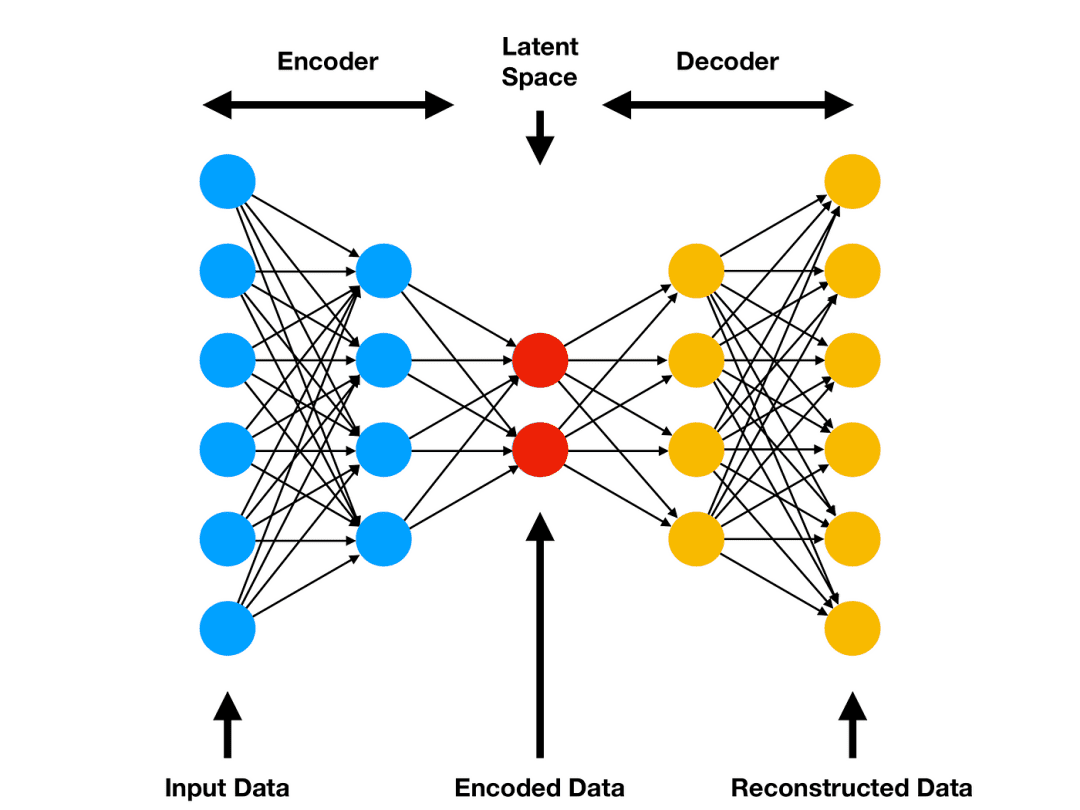

Works well for dimensionality reduction, feature learning, and anomaly detection.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)  # Bottleneck (latent space)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model, loss, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    for images, _ in train_loader:
        images = images.view(images.size(0), -1).to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

print("Training completed!")

### Denoising Autoencoder (DAE)

A Denoising Autoencoder (DAE) is a variation of autoencoders that learns to `remove noise` from corrupted inputs and reconstruct the original data.

- Structure: Similar to a vanilla autoencoder but `trained with corrupted input`.
- Objective: Reconstruct the original (clean) input from noisy input.
- Loss Function: `MSE` or `BCE `(compares the reconstructed output with clean input).
- Use Cases: Noise removal in images, speech, and time-series data.
- Implementation: `Add noise to the input` (Gaussian Noise, Salt & Pepper) before training.

In [ ]:
# Add noise to the images
def add_noise(img, noise_factor=0.5):
    img = img + noise_factor * torch.randn_like(img)
    return torch.clamp(img, 0., 1.)  # Keep values in [0,1] range

Works well for image restoration, speech denoising, and anomaly detection.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the Denoising Autoencoder model
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model, loss, and optimizer
model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    for images, _ in train_loader:
        images = images.view(images.size(0), -1).to(device)
        noisy_images = add_noise(images).to(device)

        # Forward pass
        outputs = model(noisy_images)
        loss = criterion(outputs, images)  # Compare with clean images

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

print("Training completed!")

### Sparse Autoencoder

A Sparse Autoencoder is a type of autoencoder that applies a `sparsity constraint` on the latent space to encourage `selective activation of neurons`.

This helps in `feature learning` and ensures the model captures only the most essential information. `Reduces overfitting` by forcing only a few neurons to activate for any given input.

- Structure: A standard autoencoder but with `sparsity constraint on the latent space`.
- Objective: Encourage the encoder to learn a `sparse representation` (most neurons inactive).
- Loss Function: `MSE + Sparsity Regularization` (KL Divergence, L1 norm).
- Use Cases: Feature selection, anomaly detection, high-dimensional data analysis.
- Implementation: Use `L1 regularization` (Lasso) or `KL divergence` to enforce sparsity.

        x = self.encoder(x)
        # Apply sparsity constraint using L1 regularization
        sparsity_loss = torch.mean(torch.abs(x))  # L1 norm

        # training
        loss = criterion(outputs, images) + model.sparsity_weight * sparsity_loss  # Add sparsity loss

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define Sparse Autoencoder Model
class SparseAutoencoder(nn.Module):
    def __init__(self, sparsity_weight=1e-5):
        super(SparseAutoencoder, self).__init__()
        self.sparsity_weight = sparsity_weight  # L1 regularization weight

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)  # Latent space
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        # Apply sparsity constraint using L1 regularization
        sparsity_loss = torch.mean(torch.abs(x))  # L1 norm
        x = self.decoder(x)
        return x, sparsity_loss

# Initialize model, loss function, and optimizer
model = SparseAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    for images, _ in train_loader:
        images = images.view(images.size(0), -1).to(device)

        # Forward pass
        outputs, sparsity_loss = model(images)
        loss = criterion(outputs, images) + model.sparsity_weight * sparsity_loss  # Add sparsity loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

print("Training completed!")

### Variational Autoencoder (VAE)

A Variational Autoencoder (VAE) is a `generative model` that learns a `probabilistic latent space` instead of a fixed compressed representation.

Unlike Vanilla Autoencoders, VAEs encode inputs as `distributions (mean & variance)`, allowing random sampling and controlled interpolation in the latent space.

- Structure: Instead of encoding inputs into a fixed latent vector, it learns a `probability distribution`.
- Objective: `Encode inputs into mean (μ) and variance (σ), then sample from the distribution`.
- Decoder: Reconstructs input from the sampled latent vector z.

 Encoder

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)   # Mean
        self.fc_logvar = nn.Linear(128, latent_dim)  # Log-Variance

Uses mean (μ) & variance (σ²) instead of a single latent vector.

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Sample noise
        return mu + eps * std  # Reparameterization trick

Decoder

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()  # Outputs between 0 and 1
        )


- Loss Function: Reconstruction Loss `(MSE) + KL Divergence` (ensures smooth latent space).
- Use Cases: Generative modeling, image synthesis, text generation.
- Implementation: Uses a reparameterization trick (`sampling from a normal distribution` using z = μ + σ * ε).

In [ ]:
# Loss function (Reconstruction Loss + KL Divergence)
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.BCELoss(reduction='sum')(recon_x, x)  # Binary cross-entropy loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence loss
    return recon_loss + kl_divergence

Introduces KL Divergence to make the latent space smooth & continuous.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)   # Mean
        self.fc_logvar = nn.Linear(128, latent_dim)  # Log-Variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()  # Outputs between 0 and 1
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Sample noise
        return mu + eps * std  # Reparameterization trick

    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)  # Get mean & variance
        z = self.reparameterize(mu, logvar)  # Sample latent vector
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar


# Initialize model, optimizer
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.view(images.size(0), -1).to(device)  # Flatten images

        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)  # Forward pass
        loss = loss_function(recon_images, images, mu, logvar)  # Compute loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader.dataset):.4f}")

print("Training completed!")

### Convolutional Autoencoder (CAE)

A Convolutional Autoencoder (CAE) is an autoencoder that `uses Convolutional Neural Networks (CNNs)` instead of fully connected layers.

It is particularly useful for `image-based tasks` because it captures spatial hierarchies and local patterns efficiently.

Preserves spatial structure of images.

- Structure: Uses `CNN layers` instead of fully connected layers for image processing.
- Objective: Extract `hierarchical features` and reconstruct images efficiently.
- Loss Function: `MSE` or `BCE`.
- Use Cases: Image compression, feature extraction, denoising, anomaly detection.
- Implementation: `Encoder → Conv + Pooling`, `Decoder → UpSampling + Conv`.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the Convolutional Autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # Output: 14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # Output: 7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # Output: 3x3
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # Output: 28x28
            nn.Sigmoid()  # Normalize output to [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model, loss function, and optimizer
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    for images, _ in train_loader:
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

print("Training completed!")

### Contractive Autoencoder (CAE)

A Contractive Autoencoder (CAE) is a type of autoencoder that improves the robustness of learned representations by adding a `contractive loss term`.

It penalizes the sensitivity of the latent space to small input variations, ensuring that the learned features are more stable and generalizable.

- Structure: A standard autoencoder with an `additional regularization term`.
- Objective: Improve robustness to small variations in the input.
- Loss Function: `MSE + Frobenius Norm` (penalizes sensitivity to small changes).
- Use Cases: Learning stable representations, feature extraction.
- Implementation: `Add a contractive loss term` using the **Jacobian matrix** of activations.

Loss Function:

    L = ∥X−X'∥^2 + λ∥∇Z∥^2

- Reconstruction Loss: Measures the difference between input X and output X' (Mean Squared Error - MSE).
- Jacobian Penalty: Encourages the encoder to produce a smooth and stable latent representation.

In [ ]:
# Contractive loss function
def contractive_loss(reconstruction_loss, encoded, inputs, model, lambda_val=1e-4):
    """
    Contractive Loss = Reconstruction Loss + λ * Regularization Term
    Regularization Term: Frobenius Norm of the Jacobian matrix of the encoder
    """
    # Compute the Jacobian penalty (gradient of encoded wrt input)
    W = list(model.encoder.parameters())[0]  # First layer weights
    encoded_sqr = torch.sum(encoded**2, dim=1)
    W_sqr = torch.sum(W**2, dim=1)
    jacobian_norm = torch.mean(encoded_sqr * W_sqr)  # Contractive penalty

    return reconstruction_loss + lambda_val * jacobian_norm

**Robust to Small Variations:** Unlike standard autoencoders, CAE ensures small input changes do not drastically alter the latent space.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define Contractive Autoencoder model
class ContractiveAutoencoder(nn.Module):
    def __init__(self):
        super(ContractiveAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)  # Latent space
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Initialize model, optimizer, and loss function
model = ContractiveAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse_loss = nn.MSELoss()

# Training loop
epochs = 10
lambda_val = 1e-4  # Regularization strength

for epoch in range(epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.view(images.size(0), -1).to(device)

        # Forward pass
        encoded, decoded = model(images)
        recon_loss = mse_loss(decoded, images)  # Standard reconstruction loss

        # Compute contractive loss
        loss = contractive_loss(recon_loss, encoded, images, model, lambda_val)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

print("Training completed!")

### Adversarial Autoencoder (AAE)

An Adversarial Autoencoder (AAE) combines `Autoencoders (AE) with Generative Adversarial Networks (GANs)`. It improves the latent space regularization by enforcing a prior distribution using an `adversarial loss`.

- Structure: Combines autoencoders with GANs. The encoder is trained as a generator, while the decoder acts as a discriminator.
- Objective: Enforce latent space to follow a target distribution (Gaussian, Uniform, etc.).

How AAE Works?

- Encoder: Maps input X to a latent representation Z.
- Decoder: Reconstructs X′ from Z.
- Discriminator (like in GANs): Tries to distinguish between:
  - Real samples from a desired latent distribution (e.g., Gaussian).
  - Fake samples from the encoder's output.

    Reconstruction Loss (MSE/BCE): Ensures the decoder can reconstruct input.
    Adversarial Loss (Cross-Entropy Loss): Enforces latent Z to match a target distribution.

- Loss Function: Reconstruction Loss + Adversarial Loss.
- Use Cases: Semi-supervised learning, disentangled representation learning.
- Implementation: Train the encoder adversarially using a discriminator (like GANs).

Useful for semi-supervised learning, anomaly detection, generative modeling.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define Encoder
class Encoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)  # Latent space
        )

    def forward(self, x):
        return self.model(x)

# Define Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()  # Output between 0 and 1
        )

    def forward(self, z):
        return self.model(z)

# Define Discriminator (GAN Component)
class Discriminator(nn.Module):
    def __init__(self, latent_dim=10):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Probability of being real
        )

    def forward(self, z):
        return self.model(z)

# Initialize models
latent_dim = 10
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
discriminator = Discriminator(latent_dim).to(device)

# Loss and Optimizers
reconstruction_loss = nn.MSELoss()
adversarial_loss = nn.BCELoss()
optimizer_AE = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    for images, _ in train_loader:
        images = images.view(images.size(0), -1).to(device)

        # ---------------------
        # 1. Train Autoencoder (Reconstruction)
        # ---------------------
        encoded = encoder(images)
        reconstructed = decoder(encoded)
        loss_reconstruction = reconstruction_loss(reconstructed, images)

        optimizer_AE.zero_grad()
        loss_reconstruction.backward()
        optimizer_AE.step()

        # ---------------------
        # 2. Train Discriminator (Adversarial Loss)
        # ---------------------
        real_samples = torch.randn(images.size(0), latent_dim).to(device)  # Sampled from standard normal
        fake_samples = encoder(images).detach()  # Encoded output (latent representation)

        real_preds = discriminator(real_samples)
        fake_preds = discriminator(fake_samples)

        real_loss = adversarial_loss(real_preds, torch.ones_like(real_preds))
        fake_loss = adversarial_loss(fake_preds, torch.zeros_like(fake_preds))

        loss_discriminator = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()
        loss_discriminator.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/{epochs}], Reconstruction Loss: {loss_reconstruction.item():.4f}, Discriminator Loss: {loss_discriminator.item():.4f}")

print("Training completed!")

### Beta-VAE (β-VAE)

β-VAE is an extension of Variational Autoencoders (VAEs) that introduces a hyperparameter β to control the `trade-off` between `reconstruction quality` and `disentanglement` of latent features.

- Standard VAE: Uses KL Divergence loss to ensure a smooth latent space.
  - L = Reconstruction Loss + α⋅KL Divergence
- β-VAE: Increases the KL term’s weight, forcing the model to learn more independent, interpretable latent factors.
  - Lβ = Reconstruction Loss + β⋅KL Divergence


    KL Divergence: Forces the latent space to follow a normal distribution.
    β (Beta Parameter): Controls the strength of KL regularization (higher β = stronger disentanglement).

- Structure: A variant of VAE with a β hyperparameter that controls disentanglement.
- Objective: Enforce more independent factors in the latent space.
- Loss Function: Weighted KL Divergence + Reconstruction Loss.
- Use Cases: Disentangled representation learning, generative modeling.
- Implementation: Tune β (higher values encourage disentanglement but may degrade reconstruction).

In [ ]:
beta = 4.0

Useful in generative modeling, representation learning, and explainable AI.

Can be extended to image synthesis (VQ-VAE, StyleGAN), disentangled learning, and structured latent spaces.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define Beta-VAE Model
class BetaVAE(nn.Module):
    def __init__(self, latent_dim=10, beta=4.0):  # Increase β for stronger disentanglement
        super(BetaVAE, self).__init__()
        self.beta = beta  # Control disentanglement strength

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)  # Mean
        self.fc_logvar = nn.Linear(128, latent_dim)  # Log variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()  # Output range [0,1]
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + self.beta * kl_div  # Adjusted KL weight

# Load Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BetaVAE(latent_dim=10, beta=4.0).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)

        optimizer.zero_grad()
        recon_images, mu, logvar = model(images)
        loss = model.loss_function(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader.dataset):.4f}")

print("Training complete!")

### Vector Quantized VAE (VQ-VAE)

VQ-VAE is a variant of the Variational Autoencoder (VAE) that uses a `discrete latent space` instead of a continuous one.

This makes it useful for `generative tasks` like image synthesis (DALL·E), speech generation (WaveNet), and text-to-image models.

- Structure: Uses discrete latent variables instead of continuous ones.
- Objective: Learn a codebook of discrete latent vectors for better generation.
- Loss Function: Reconstruction Loss + Codebook Loss (ensures proper discrete encoding).
- Use Cases: DALL·E, GPT-like image synthesis, text-to-image models.
- Implementation: Uses a discrete codebook to force latent vectors into a limited set of representations.

`No KL divergence loss` (as in VAEs). Instead, it uses a `codebook loss` to ensure latent vectors stay close to discrete embeddings.

Architecture of VQ-VAE
- Encoder – Converts input into a feature map (latent representation).
- Vector Quantization (Codebook) – Maps latent vectors to the closest codebook vectors.
- Decoder – Reconstructs the input using the quantized latent space.
- Commitment Loss – Ensures encoded vectors stay close to the chosen codebook vectors.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.nn.functional as F

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Vector Quantization Layer
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings=128, embedding_dim=32, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.commitment_cost = commitment_cost

        # Codebook (Embedding Table)
        self.embeddings = nn.Embedding(num_embeddings, embedding_dim)
        self.embeddings.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def forward(self, x):
        # Reshape input to (batch_size, num_features)
        flat_x = x.view(-1, self.embedding_dim)

        # Compute L2 distance between input and embedding table
        distances = (torch.sum(flat_x**2, dim=1, keepdim=True)
                     + torch.sum(self.embeddings.weight**2, dim=1)
                     - 2 * torch.matmul(flat_x, self.embeddings.weight.t()))

        # Get nearest embedding index
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)

        # Quantized output from embedding table
        quantized = self.embeddings(encoding_indices).view(x.shape)

        # Commitment loss
        loss = self.commitment_cost * F.mse_loss(quantized.detach(), x)

        # Straight-through estimator: Pass gradients to input
        quantized = x + (quantized - x).detach()

        return quantized, loss

# Define VQ-VAE Model
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=128, embedding_dim=32):
        super(VQVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_dim)
        )

        # Vector Quantizer
        self.vq = VectorQuantizer(num_embeddings, embedding_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten image
        encoded = self.encoder(x)
        quantized, vq_loss = self.vq(encoded)
        decoded = self.decoder(quantized)
        return decoded, vq_loss

# Initialize Model, Loss, and Optimizer
model = VQVAE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)

        # Forward Pass
        reconstructed, vq_loss = model(images)
        loss = criterion(reconstructed, images.view(images.size(0), -1)) + vq_loss

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}")

print("Training Completed!")

Applications of VQ-VAE

- Image Generation (DALL·E, VQ-GAN) – Generates high-quality images from text.
- Speech Synthesis (WaveNet) – Used in Google’s text-to-speech models.
- Video Prediction – Predicts future frames in a video.
- Disentangled Representation Learning – Learns structured representations of data.

### Transformer Autoencoders

ransformer Autoencoders leverage the power of `self-attention mechanisms` (from Transformers) instead of traditional CNNs or RNNs for encoding and decoding data.

They are highly effective in text generation, speech processing, and image reconstruction.

- Structure: Uses self-attention mechanisms instead of CNNs/RNNs.
- Objective: Capture long-range dependencies in text, images, and audio.
- Loss Function: Cross-Entropy for text, MSE for images.
- Use Cases: Text representation learning (BERT), Speech synthesis, Image inpainting.
- Implementation: Uses Transformer encoders & decoders (Multi-Head Attention, Positional Encoding).

Architecture of a Transformer Autoencoder

- Encoder: Uses a stack of Transformer Encoder Layers to convert input into a latent representation.
- Decoder: Uses Transformer Decoder Layers to reconstruct the original input from the latent space.
- Positional Encoding: Since transformers lack sequential bias, we add positional embeddings.
- Loss Function: Mean Squared Error (MSE) or Cross-Entropy to compare input vs. reconstructed output.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define Transformer Autoencoder Model
class TransformerAutoencoder(nn.Module):
    def __init__(self, input_dim=512, embed_dim=128, num_heads=4, num_layers=3):
        super(TransformerAutoencoder, self).__init__()

        # Positional Encoding (Ensures order awareness)
        self.positional_encoding = nn.Embedding(100, embed_dim)

        # Encoder: Transformer Encoder Layer
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)

        # Decoder: Transformer Decoder Layer
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=embed_dim, nhead=num_heads)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_layers)

        # Input and Output Projection Layers
        self.input_projection = nn.Linear(input_dim, embed_dim)
        self.output_projection = nn.Linear(embed_dim, input_dim)

    def forward(self, x):
        seq_length, batch_size, _ = x.shape  # (Seq_len, Batch, Input_dim)
        positions = torch.arange(seq_length).unsqueeze(1).expand(seq_length, batch_size).to(x.device)
        x = self.input_projection(x) + self.positional_encoding(positions)

        # Encode
        latent_representation = self.encoder(x)

        # Decode
        reconstructed = self.decoder(latent_representation, latent_representation)
        reconstructed = self.output_projection(reconstructed)
        return reconstructed

# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Dummy Data (Simulating Input)
batch_size = 32
seq_length = 50
input_dim = 512
dummy_input = torch.randn(seq_length, batch_size, input_dim).to(device)

# Train Model for One Step
model.train()
optimizer.zero_grad()
output = model(dummy_input)
loss = criterion(output, dummy_input)
loss.backward()
optimizer.step()

print(f"Initial Training Loss: {loss.item():.4f}")

### Masked Autoencoder (MAE)

Masked Autoencoder (MAE) is a self-supervised learning technique used for learning deep representations, especially in computer vision (e.g., image inpainting, feature learning). It is inspired by the Masked Language Model (MLM) from BERT, but applied to images.

- The input image is divided into non-overlapping patches (like ViTs).
- A large fraction (e.g., 75%) of patches are randomly masked.
- Only the remaining patches are given to the encoder.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from timm.models.vision_transformer import VisionTransformer
import numpy as np

# -------------------------
# Masked Autoencoder Model
# -------------------------

class MaskedAutoencoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, embed_dim=768, mask_ratio=0.75):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.mask_ratio = mask_ratio

        # Vision Transformer Encoder (only visible patches)
        self.encoder = VisionTransformer(img_size=img_size, patch_size=patch_size, embed_dim=embed_dim, depth=12, num_heads=12)

        # Decoder (reconstruct masked patches)
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, img_size * img_size * 3)  # Output size (reconstructed image)
        )

    def forward(self, x):
        # Convert image into patches
        batch_size, _, H, W = x.shape
        num_patches = (H // self.patch_size) * (W // self.patch_size)

        # Flatten into patches
        x = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 3, 1, 4, 5).reshape(batch_size, num_patches, -1)

        # Apply random masking
        mask = torch.rand(batch_size, num_patches) < self.mask_ratio
        masked_x = x.clone()
        masked_x[mask] = 0  # Set masked patches to 0

        # Encode only visible patches
        encoded = self.encoder(masked_x)

        # Decode and reconstruct masked patches
        reconstructed = self.decoder(encoded)

        return reconstructed, mask

# -------------------------
# Training Setup
# -------------------------

# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MaskedAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Load dataset (CIFAR-10 as example)
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Train the model
for epoch in range(10):
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        reconstructed, mask = model(imgs)

        # Compute loss on **only masked** patches
        loss = criterion(reconstructed[mask], imgs.view(imgs.shape[0], -1)[mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

## Advanced Autoencoder Techniques

### Self-Supervised Learning with Autoencoders

Self-supervised learning (SSL) is a form of unsupervised learning where the model `generates its own labels from data`. Autoencoders play a key role in SSL by learning meaningful latent representations without requiring labeled data.

**SSL Framework Using Autoencoders**

Step 1: Define a Pretext Task (Self-Supervised Learning Objective)
- Reconstruction Task – Train an autoencoder to reconstruct input data
- Denoising Task – Train a denoising autoencoder (DAE) to remove noise
- Inpainting Task – Mask parts of an image and predict missing regions
- Contrastive Learning with Autoencoders – Learn invariant representations

Step 2: Train the Autoencoder on Unlabeled Data
- Encoder learns a compressed representation (latent space)
- Decoder reconstructs the original input

Step 3: Use the Learned Representations for Downstream Tasks
- Feature Extraction for Classification
- Clustering (K-Means, t-SNE, UMAP on latent space)
- Anomaly Detection (Compare reconstruction errors)

**Why Use Autoencoders for Self-Supervised Learning?**

- Unlabeled Data Utilization – No need for labeled datasets
- Feature Learning – Extracts rich feature representations
- Data Augmentation-Friendly – Works well with transformations
- Downstream Tasks – Helps in classification, clustering, anomaly detection

### Neural Style Transfer using Autoencoders

Neural Style Transfer (NST) is a deep learning technique that combines the content of one image with the artistic style of another. While traditional NST uses pretrained CNNs like VGG-19, autoencoders offer an efficient and flexible alternative for real-time style transfer.